In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

In [2]:
data =  pd.read_csv('/content/temp.csv', header=0)
train_percent=0.60
num_epochs=150

In [3]:
data.head()

,Tem,Year
0,16.9760,1-Jan-01
1,19.9026,1-Feb-01
2,24.3158,1-Mar-01
3,28.1834,1-Apr-01
4,27.8892,1-May-01


In [4]:
print(len(data['Tem'].unique()))
symbols = data['Tem'].unique()

1460


In [5]:
data['Tem'].describe()

count    1474.000000
mean       25.066443
std         3.701075
min        15.925161
25%        22.121579
50%        27.012950
75%        28.032675
max        29.526000
Name: Tem, dtype: float64

In [6]:
#random.seed(42)  #explain!
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

29.5091


In [7]:
data_mod = data.drop(['Year'], axis=1)

In [8]:
data_mod

,Tem
0,16.976000
1,19.902600
2,24.315800
3,28.183400
4,27.889200
...,...
1469,28.586394
1470,28.533089
1471,28.451926
1472,27.737212


In [9]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_mod_scaled = sc.fit_transform(data_mod)

In [10]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [11]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_mod_scaled, n_future=1, n_past=25, train_test_split_percentage=train_percent,
                                               validation_split_percentage = 0)


In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(869, 25, 1)
(580, 25, 1)
(869, 1)
(580, 1)


In [13]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=64)
#history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=64, callbacks=[es])

Epoch 1/150
10/10 [==============================] - 6s 88ms/step - loss: 0.2629 - root_mean_squared_error: 0.5127 - val_loss: 0.1418 - val_root_mean_squared_error: 0.3766
Epoch 2/150
10/10 [==============================] - 0s 11ms/step - loss: 0.1199 - root_mean_squared_error: 0.3463 - val_loss: 0.0903 - val_root_mean_squared_error: 0.3005
Epoch 3/150
10/10 [==============================] - 0s 11ms/step - loss: 0.1113 - root_mean_squared_error: 0.3336 - val_loss: 0.0826 - val_root_mean_squared_error: 0.2874
Epoch 4/150
10/10 [==============================] - 0s 11ms/step - loss: 0.1018 - root_mean_squared_error: 0.3191 - val_loss: 0.0854 - val_root_mean_squared_error: 0.2922
Epoch 5/150
10/10 [==============================] - 0s 11ms/step - loss: 0.1023 - root_mean_squared_error: 0.3199 - val_loss: 0.0825 - val_root_mean_squared_error: 0.2872
Epoch 6/150
10/10 [==============================] - 0s 11ms/step - loss: 0.0964 - root_mean_squared_error: 0.3104 - val_loss: 0.0810 - val_

In [15]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

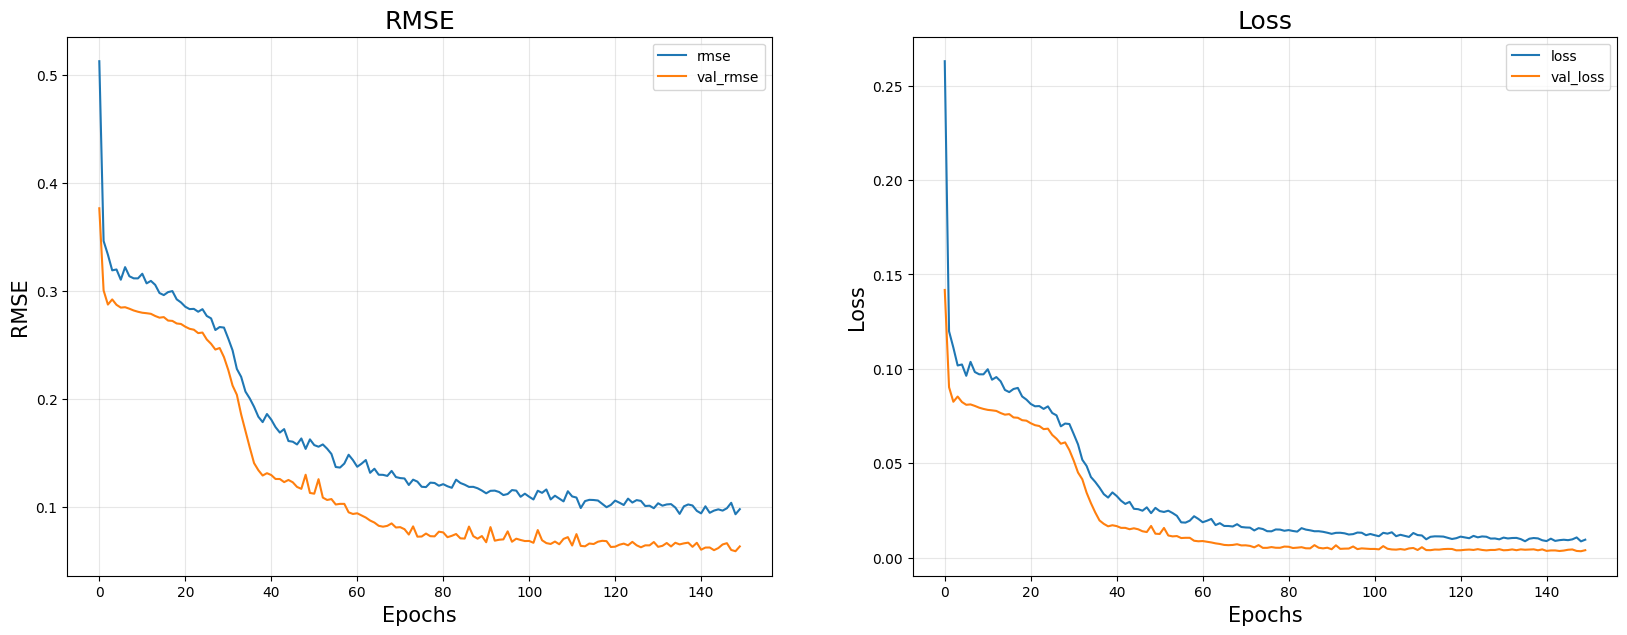

In [16]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)
# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")
plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#Adding Subplot 1 (For Loss)
fig.add_subplot(122)
plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")
plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [17]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

19/19 [==============================] - 0s 4ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703
test loss, test acc: [0.0049 0.0703]


In [18]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
from keras.layers import Bidirectional , GRU

def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, callbacks=[es, mc], verbose=1)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [19]:
config = [[False], [False], [False], [8,16, 32, 64, 128], [8, 16, 32, 64, 128], [0.2,0.3,0.5]]
# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]
hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 8, 8, 0.2), (False, False, False, 8, 8, 0.3), (False, False, False, 8, 8, 0.5), (False, False, False, 8, 16, 0.2), (False, False, False, 8, 16, 0.3), (False, False, False, 8, 16, 0.5), (False, False, False, 8, 32, 0.2), (False, False, False, 8, 32, 0.3), (False, False, False, 8, 32, 0.5), (False, False, False, 8, 64, 0.2), (False, False, False, 8, 64, 0.3), (False, False, False, 8, 64, 0.5), (False, False, False, 8, 128, 0.2), (False, False, False, 8, 128, 0.3), (False, False, False, 8, 128, 0.5), (False, False, False, 16, 8, 0.2), (False, False, False, 16, 8, 0.3), (False, False, False, 16, 8, 0.5), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 16, 0.3), (False, False, False, 16, 16, 0.5), (False, False, False, 16, 32, 0.2), (False, False, False, 16, 32, 0.3), (False, False, False, 16, 32, 0.5), (False, False, False, 16, 64, 0.2), (False, False, False, 16, 64, 0.3), (False, False, False, 16, 64, 0.5), (False, False, False, 16, 128, 0.2), (False, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - root_mean_squared_error: 0.1240
Epoch 121: val_loss improved from 0.00640 to 0.00595, saving model to best_model.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 122/150
1/5 [=====>........................] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1204
Epoch 122: val_loss did not improve from 0.00595
5/5 [==============================] - 0s 20ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781
Epoch 123/150
1/5 [=====>........................] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1023
Epoch 123: val_loss improved from 0.00595 to 0.00562, saving model to best_model.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0130 - root_mean_squared_error: 0.1138

In [20]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
63,False,False,False,128,16,0.2,"[0.0029006083495914936, 0.05385729670524597]","[0.003244201187044382, 0.05695788934826851]"
64,False,False,False,128,16,0.3,"[0.003044928191229701, 0.0551808662712574]","[0.003454510821029544, 0.05877508595585823]"
58,False,False,False,64,128,0.3,"[0.0036110151559114456, 0.06009172275662422]","[0.003593015717342496, 0.059941768646240234]"
66,False,False,False,128,32,0.2,"[0.003444818314164877, 0.0586925745010376]","[0.0036628847010433674, 0.060521770268678665]"
71,False,False,False,128,64,0.5,"[0.0037937213201075792, 0.0615931898355484]","[0.003675030544400215, 0.06062202900648117]"
...,...,...,...,...,...,...,...,...
5,False,False,False,8,16,0.5,"[0.07947433739900589, 0.2819119393825531]","[0.08189127594232559, 0.2861665189266205]"
12,False,False,False,8,128,0.2,"[0.08279261738061905, 0.28773707151412964]","[0.08356722444295883, 0.2890799641609192]"
14,False,False,False,8,128,0.5,"[0.08546940982341766, 0.29235151410102844]","[0.08711054176092148, 0.2951449453830719]"
11,False,False,False,8,64,0.5,"[0.08592832833528519, 0.2931353449821472]","[0.08801696449518204, 0.29667651653289795]"


In [21]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 128
 n_batch_size = 16
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0703

Results After Tunning:
 Test Set RMSE: 0.057

19.0% Improvement


In [22]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [23]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history_2=regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, verbose=1)
#history_2=regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, callbacks=[es], verbose=1)

Epoch 1/150
38/38 [==============================] - 4s 27ms/step - loss: 0.1135 - root_mean_squared_error: 0.3369 - val_loss: 0.0920 - val_root_mean_squared_error: 0.3034
Epoch 2/150
38/38 [==============================] - 0s 7ms/step - loss: 0.0826 - root_mean_squared_error: 0.2875 - val_loss: 0.0842 - val_root_mean_squared_error: 0.2901
Epoch 3/150
38/38 [==============================] - 0s 8ms/step - loss: 0.0667 - root_mean_squared_error: 0.2582 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1548
Epoch 4/150
38/38 [==============================] - 0s 7ms/step - loss: 0.0229 - root_mean_squared_error: 0.1513 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 5/150
38/38 [==============================] - 0s 7ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 6/150
38/38 [==============================] - 0s 7ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0073 - val_root_

In [24]:
regressor.evaluate(X_test, y_test)

19/19 [==============================] - 0s 5ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599


[0.0035834896843880415, 0.05986225605010986]

In [25]:
history_2.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

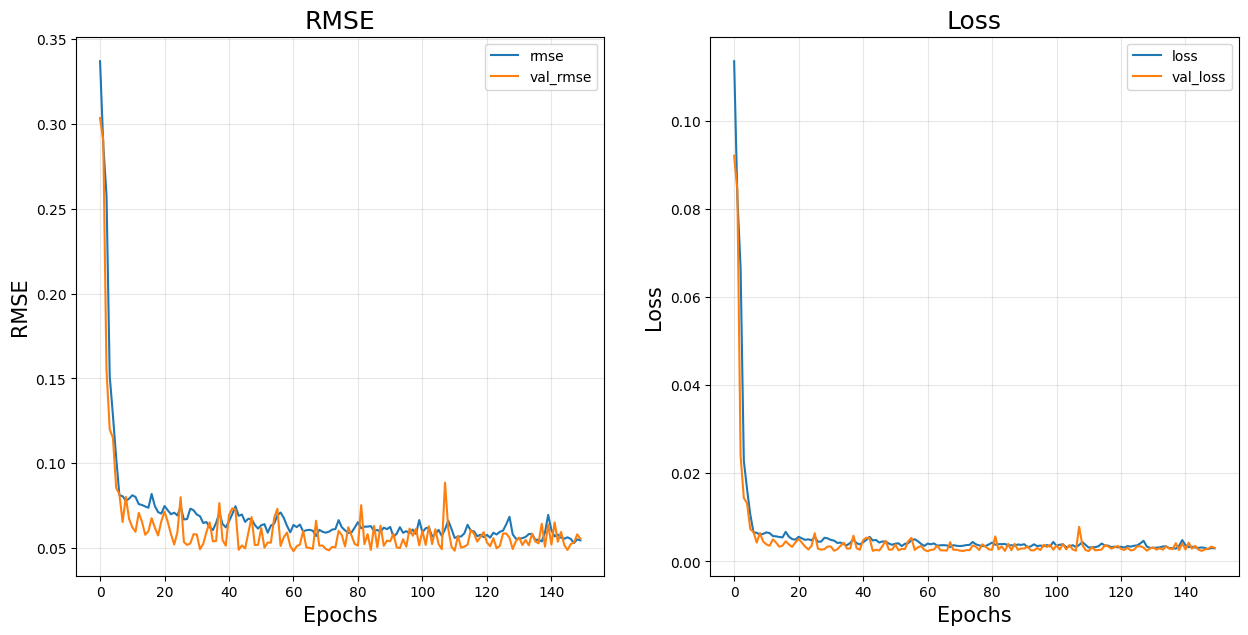

In [26]:
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
# Accuracy
plt.plot(history_2.epoch, history_2.history['root_mean_squared_error'], label = "rmse")
plt.plot(history_2.epoch, history_2.history['val_root_mean_squared_error'], label = "val_rmse")
plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#Adding Subplot 1 (For Loss)
fig.add_subplot(122)
plt.plot(history_2.epoch, history_2.history['loss'], label="loss")
plt.plot(history_2.epoch, history_2.history['val_loss'], label="val_loss")
plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

19/19 [==============================] - 1s 3ms/step


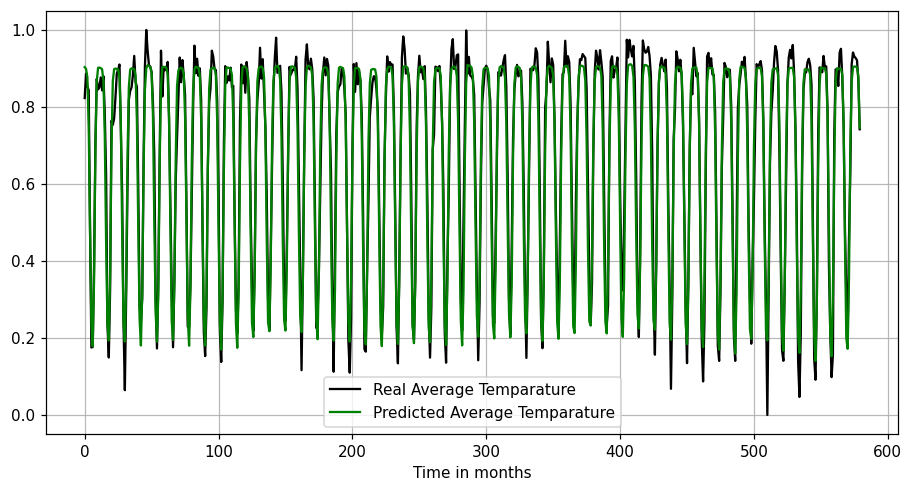

In [27]:
y_pred = regressor.predict(X_test)
plt.figure(figsize=(10,5), dpi= 110, facecolor='w', edgecolor='k')
plt.plot(y_test, color='black', label = 'Real Average Temparature')
plt.plot(y_pred, color='green', label = 'Predicted Average Temparature')
plt.legend(loc='best')
plt.xlabel('Time in months')
plt.grid(alpha=0.9)
plt.legend()


19/19 [==============================] - 0s 3ms/step


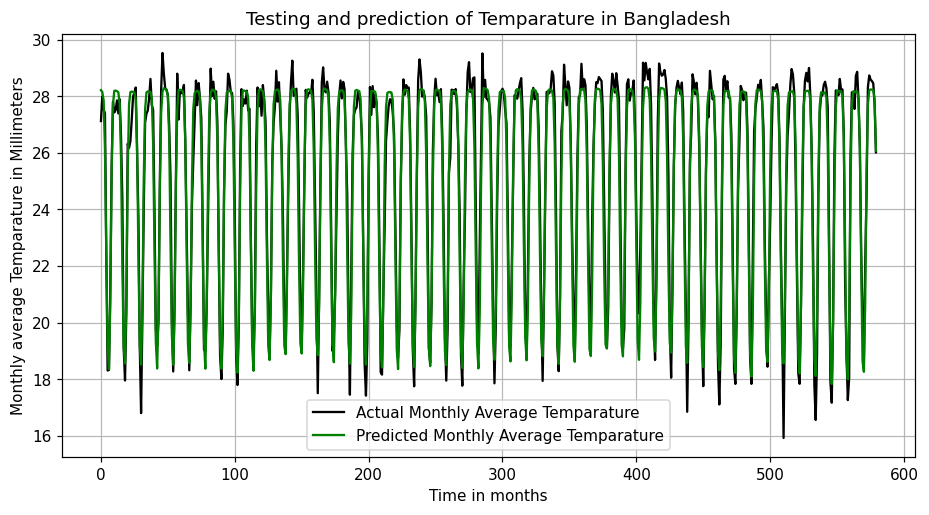

In [28]:
y_pred = regressor.predict(X_test)
plt.figure(figsize=(10,5), dpi= 110, facecolor='w', edgecolor='k')
y_test_sc = sc.inverse_transform(y_test)
y_pred_sc = sc.inverse_transform(y_pred)
plt.plot(y_test_sc, color='black', label = 'Actual Monthly Average Temparature')
plt.plot(y_pred_sc, color='green', label = 'Predicted Monthly Average Temparature')
plt.legend(loc='best')
plt.ylabel('Monthly average Temparature')
plt.xlabel('Time in months')
plt.ylabel('Tem')
plt.ylabel('Monthly average Temparature in Millimeters')
plt.title('Testing and prediction of Temparature in Bangladesh')
plt.grid(alpha=0.9)
plt.legend()

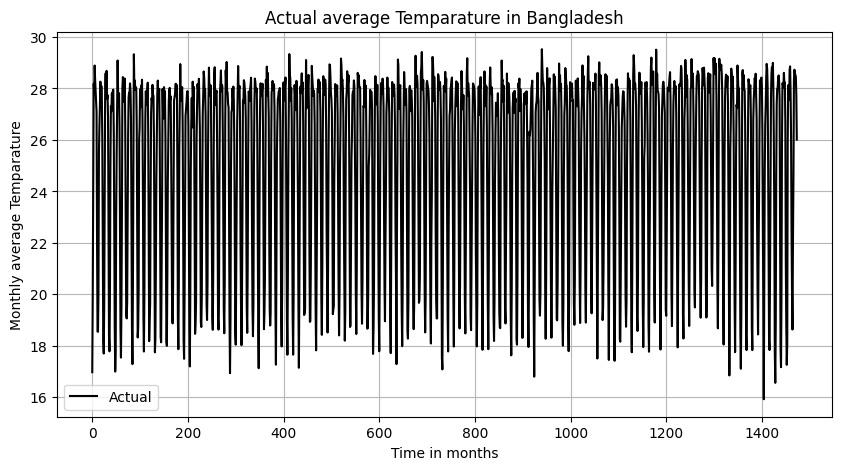

In [29]:
plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(data['Tem'], color='black', label = 'Actual')
plt.grid(alpha=0.9)
plt.xlabel('Time in months')
plt.ylabel('Monthly average Temparature')
plt.title('Actual average Temparature in Bangladesh')
plt.legend(loc='best')

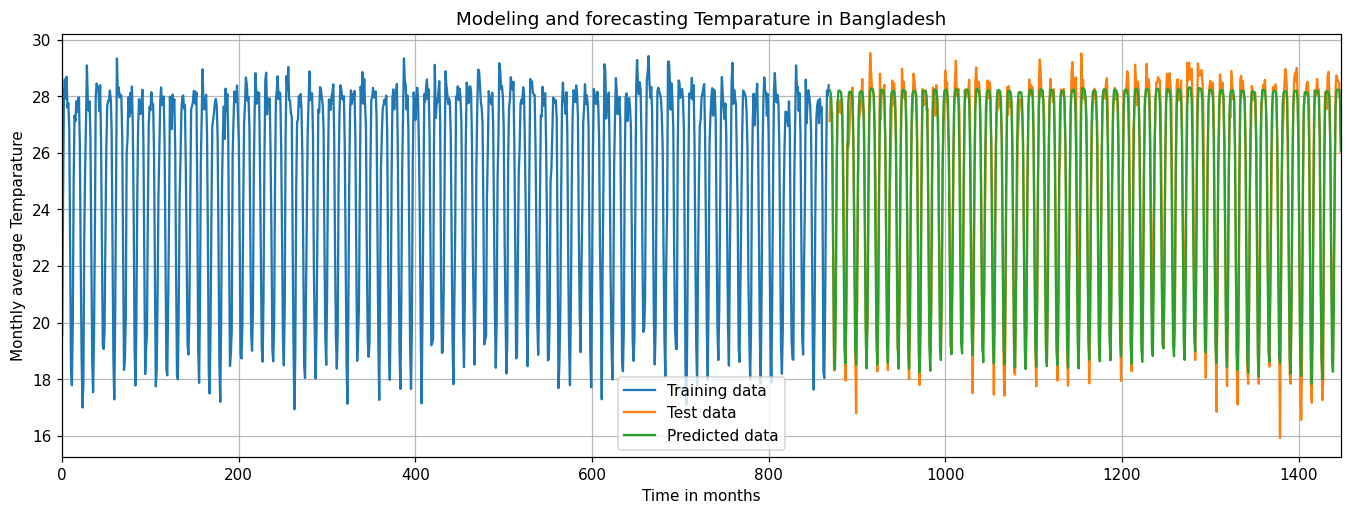

In [30]:
import matplotlib.pyplot as plt
# Create an array of time values corresponding to the length of each dataset
time_train = range(len(y_train))
time_test = range(len(y_train), len(y_train) + len(y_test))
fig = plt.figure(figsize=(15,5), dpi= 110)
# Plot the data using line plots with time on the x-axis
plt.plot(time_train, sc.inverse_transform(y_train), label='Training data')
plt.plot(time_test, sc.inverse_transform(y_test), label='Test data')
plt.plot(time_test, sc.inverse_transform(y_pred), label='Predicted data')
plt.legend()
plt.xlabel('Time in months')
plt.ylabel('Tem')
plt.ylabel('Monthly average Temparature')
plt.title('Modeling and forecasting Temparature in Bangladesh')
plt.legend(loc='best')
plt.grid(alpha=0.9)
plt.xlim([min(time_train), max(time_test)])
plt.grid(alpha=0.9)
plt.show()

In [31]:
# set x_forcast to be the input data
x_forcast = X_test[-1::]
y_forcast = []
n_forecast=730
for _ in range(n_forecast):

    # predict y values with the regression model
    y_forcast_temp = regressor.predict(x_forcast)
    x_forcast = np.append(x_forcast[:,1:,:], np.array(y_forcast_temp).reshape(1,1,1), axis=1)


    # append the y_forcast to the end of x_forcast
    y_forcast.append(y_forcast_temp.reshape(1))


1/1 [==============================] - 0s 26ms/step


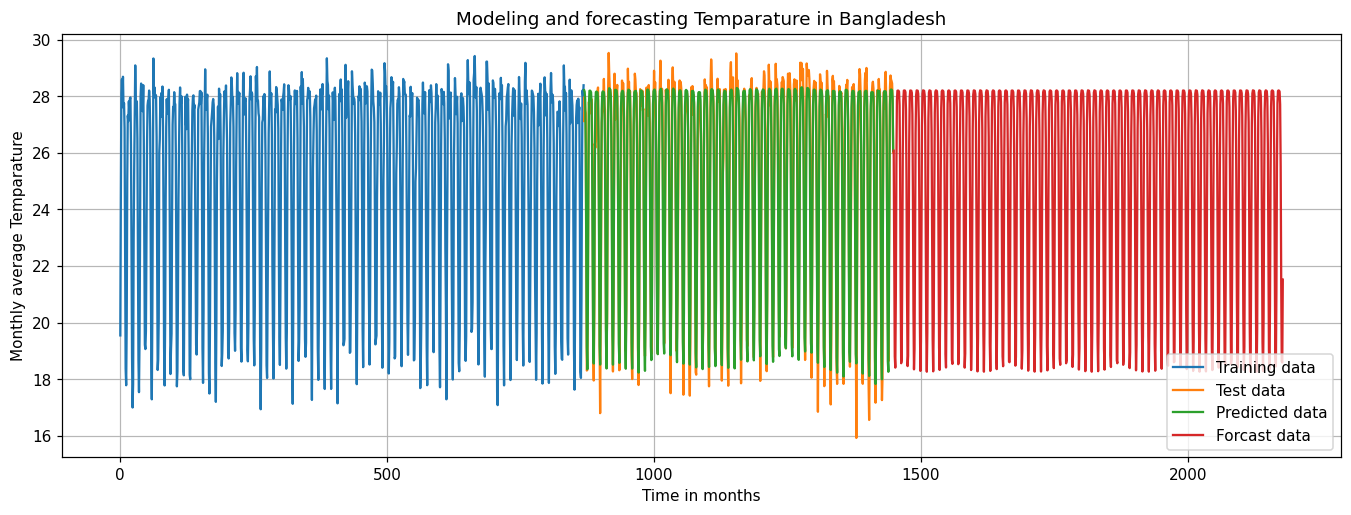

In [32]:
import matplotlib.pyplot as plt
# Create an array of time values corresponding to the length of each dataset
time_train = range(len(y_train))
time_test = range(len(y_train), len(y_train) + len(y_test))
time_forecast = range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_forcast))
fig = plt.figure(figsize=(15,5), dpi= 110)
# Plot the data using line plots with time on the x-axis
plt.plot(time_train, sc.inverse_transform(y_train), label='Training data')
plt.plot(time_test, sc.inverse_transform(y_test), label='Test data')
plt.plot(time_test, sc.inverse_transform(y_pred), label='Predicted data')
plt.plot(time_forecast, sc.inverse_transform(y_forcast), label='Forcast data')
plt.legend()
plt.xlabel('Time in months')
plt.ylabel('Tem')
plt.ylabel('Monthly average Temparature')
plt.title('Modeling and forecasting Temparature in Bangladesh')
plt.legend(loc='best')
plt.grid(alpha=0.9)
# plt.xlim([min(time_train), max(time_forecast)])
plt.grid(alpha=0.9)
plt.show()

In [33]:
X_train.shape

(869, 25, 1)

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test_sc, y_pred_sc)   # 5500
mae = mean_absolute_error(y_test_sc, y_pred_sc)
mape = mean_absolute_percentage_error(y_test_sc, y_pred_sc)*100
r2_Squared = r2_score(y_test_sc, y_pred_sc)
rmse = np.sqrt(mse)
rrmse= np.sqrt(rmse)
print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print('X_test MAPE:{}%'.format(mape))
#print(f'X_test RMSLE: {rmsle}')
print(f'R-Squared: {r2_Squared}')
print(f'X_test RMSE: {rmse}')
print(f'X_test RRMSE: {rrmse}')

X_test MSE: 0.6628839450494459
X_test MAE: 0.6151265067507997
X_test MAPE:2.561930092833013%
R-Squared: 0.9510822210035745
X_test RMSE: 0.8141768512119747
X_test RRMSE: 0.9023174891422502
